In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# **Extratrees**

In [51]:
df  = pd.read_csv("../data/processed/agg_data_ml.csv")
X = df.drop(columns=['Data', 'Eólica'])  # Features
y = df['Eólica']                          # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [52]:
modelo = ExtraTreesRegressor(n_estimators=500, random_state=42)
modelo.fit(X_train, y_train)


ExtraTreesRegressor(n_estimators=500, random_state=42)

In [53]:
y_pred = modelo.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.8331
MAE: 26831.69
RMSE: 35308.36


R² = 0.8331 → Excelente capacidade de explicação da variabilidade dos dados.

MAE = 26.831.69 kWh → Erro médio absoluto relativamente baixo para valores de produção diários.

RMSE = 35.308 kWh → Penaliza mais os erros maiores, ainda assim bastante razoável.

In [54]:
# Carregar o ficheiro com os dados reais
dados_reais = pd.read_csv("../data/processed/agg_data_ml.csv")
df_previsoes = pd.read_csv("../tests/previsoes_eolica_extratrees.csv")

# Converter a coluna 'Data' para datetime para cruzamento
df_previsoes['Data'] = pd.to_datetime(df_previsoes['Data'])
dados_reais['Data'] = pd.to_datetime(dados_reais['Data'])

# Juntar previsões com valores reais
df_analise = pd.merge(df_previsoes, dados_reais[['Data', 'Eólica']], on='Data', how='inner')
df_analise.rename(columns={'Eólica': 'Eolica_Real'}, inplace=True)

# Verificar estrutura
df_analise.head(25)

,Data,Eolica_Prevista,Eolica_Real
0,2013-01-02,118865.500,118865.5
1,2013-01-03,232257.700,232257.7
2,2013-01-04,149543.700,149543.7
3,2013-01-05,23830.800,23830.8
4,2013-01-06,19526.800,19526.8
5,2013-01-07,9623.000,9623.0
6,2013-01-08,94561.981,39302.3
7,2013-01-09,120576.800,120576.8
8,2013-01-10,84039.006,65510.1
9,2013-01-11,58813.800,58813.8


In [55]:
error = abs(df_analise['Eolica_Real'] - df_analise['Eolica_Prevista']) / df_analise['Eolica_Real'] * 100
print(f"Erro médio percentual: {error.mean():.2f}%")

Erro médio percentual: 6.02%


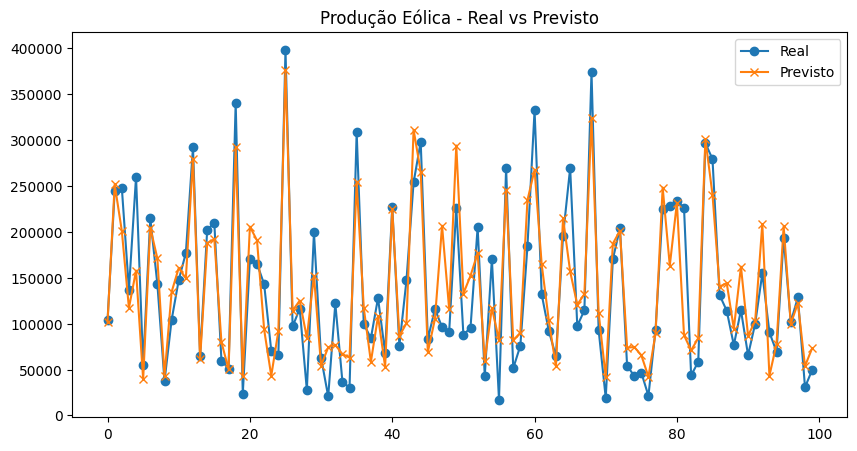

In [56]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Real', marker='o')
plt.plot(y_pred[:100], label='Previsto', marker='x')
plt.legend()
plt.title('Produção Eólica - Real vs Previsto')
plt.show()

# **ANN**

In [65]:
# Definir X (com Data incluída) e y
X_full = df[['Data', 'Intensidade_Media', 'Direcao_Media', 'Temperatura_Media',
             'mes', 'dia_da_semana', 'vento_sin', 'vento_cos',
             'Intensidade_Media_lag1', 'Temperatura_Media_lag1', 'Eólica_lag1']]
y = df['Eólica']

# Fazer split em treino/teste com X_full (incluindo Data)
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=42)

# Separar colunas numéricas (sem 'Data') para normalização
features = ['Intensidade_Media', 'Direcao_Media', 'Temperatura_Media',
            'mes', 'dia_da_semana', 'vento_sin', 'vento_cos',
            'Intensidade_Media_lag1', 'Temperatura_Media_lag1', 'Eólica_lag1']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full[features])
X_test_scaled = scaler.transform(X_test_full[features])

# Construir e treinar o modelo ANN
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ann_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


c:\Users\User\Documents\GitHub\wind-energy-forecast\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 25665617920.0000 - mae: 134104.4375 - val_loss: 26103517184.0000 - val_mae: 136510.2969
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26203625472.0000 - mae: 135529.4062 - val_loss: 26094993408.0000 - val_mae: 136484.8438
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25876682752.0000 - mae: 135373.5625 - val_loss: 26069741568.0000 - val_mae: 136412.7656
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24459919360.0000 - mae: 130943.4219 - val_loss: 26015543296.0000 - val_mae: 136262.0469
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25862961152.0000 - mae: 134496.0938 - val_loss: 25921222656.0000 - val_mae: 136004.5938
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25607077888.0000 - mae: 133576.9844 - val_loss: 25776334848.0000 - val_mae: 135613.1406
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25226121216.0000 - mae: 133008.4219 - val_loss: 25574508544.0000 - val_

In [69]:
# Previsões
predictions = ann_model.predict(X_test_scaled)

# Construir DataFrame com resultados
results = pd.DataFrame({
    'Data': X_test_full['Data'].values,
    'Real': y_test.values,
    'Previsao': predictions.flatten()
})

# Ordenar por data e guardar
results['Data'] = pd.to_datetime(results['Data'])
results = results.sort_values('Data')
results.to_csv("previsoes_ann_paper.csv", index=False)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [70]:
media_eolica = df['Eólica'].mean()
desvio_padrao_eolica = df['Eólica'].std()

print(f"Média: {media_eolica:.2f}")
print(f"Desvio Padrão: {desvio_padrao_eolica:.2f}")

Média: 135119.17
Desvio Padrão: 86990.83


In [71]:
error = abs(results['Real'] - results['Previsao']) / results['Real'] * 100
print(f"Erro médio percentual: {error.mean():.2f}%")

Erro médio percentual: 35.26%
